# Imports

In [ ]:
import sys
 
# setting path
sys.path.append('..')

In [ ]:
from model_builder import ModelBuilder
import matplotlib.pyplot as plt

# Model

In [ ]:
model_builder = ModelBuilder()

# Create Dataset

In [ ]:
response_variable=['Response_Variable_Brazil_Atlantic_Forest_0forest_1deforested']
# feature_names=['brazil_roads','elevation','slope','brazil_protected_areas','population_density','forest_age','urbanization',
#                'brazil_surrounding_forest','brazil_pasture','brazil_agriculture','south_america_rivers','urban_distance']

feature_names = ['elevation', 'slope', 'south_america_rivers', 'brazil_roads', 'urban_distance', 'brazil_protected_areas', 
                 'brazil_surrounding_forest', 'brazil_pasture', 'brazil_agriculture', 'population_density', 'forest_age', 'urbanization']

# feature_names = ['elevation', 'slope', 'distRivers', 'distRoads', 'distUrban', 'distPA', 
#                'forest', 'pasture', 'agriculture', 'populationDensity', 'forestAge', 'urbanization']
# response_variable=['response']


gcp_bucket = 'eartshot-science-team'
gcp_folder_name = 'deforestation_risk'
samples_folder_name = f'Brazil_Atlantic_Forest_10km2_grids_samples_csv_scale30_1000numPoints'
name_csv_samples_merged_file = 'Brazil_Atlantic_Forest_10km2_grids_samples_csv_scale30_1000numPoints_val_test_set_10km_buffer.csv'
name_csv_samples_merged_file = '/Users/margauxmforstyhe/Desktop/workspace/Earthshot Labs/workspace/Science/science/Global_UNR_model/Mature_Forest_Biomass/temp/Brazil_Atlantic_Forest_10km2_grids_samples_csv_scale30_1000numPoints_val_test_set_10km_buffer.csv'

# samples_folder_name = f'deforestationRisk_MA_samples'
# name_csv_samples_merged_file = '/Users/margauxmforstyhe/Desktop/deforestationRisk_MA_renamed2.csv'

In [ ]:
model_builder.create_dataset(response_variable=response_variable, 
                             samples_csv_local=True,
                             feature_names=feature_names, 
                             gcp_bucket=gcp_bucket, 
                             gcp_folder_name=gcp_folder_name, 
                             samples_folder_name= samples_folder_name, 
                             name_csv_samples_merged_file = name_csv_samples_merged_file, 
                             use_test_val_buffered_sets = True,
                             name_test_buffer_column='test_set_5km_buffer', 
                             name_val_buffer_column='val_set_5km_buffer', 
                             name_test_no_buffer_column='test_set_no_buffer', 
                             name_val_no_buffer_column='val_set_no_buffer')

In [ ]:
model_builder.X_train.head()

In [ ]:
model_builder.y_train.head()

In [ ]:
nb_forest_samples = model_builder.y_train[model_builder.y_train[response_variable[0]] == 0][response_variable[0]].count()
nb_deforested_samples = model_builder.y_train[model_builder.y_train[response_variable[0]] == 1][response_variable[0]].count()
print(f'There are {nb_forest_samples} forest samples and {nb_deforested_samples} deforested samples in training set')

nb_forest_samples = model_builder.y_val[model_builder.y_val[response_variable[0]] == 0][response_variable[0]].count()
nb_deforested_samples = model_builder.y_val[model_builder.y_val[response_variable[0]] == 1][response_variable[0]].count()
print(f'There are {nb_forest_samples} forest samples and {nb_deforested_samples} deforested samples in validation set')

nb_forest_samples_test = model_builder.y_test[model_builder.y_test[response_variable[0]] == 0][response_variable[0]].count()
nb_deforested_samples_test = model_builder.y_test[model_builder.y_test[response_variable[0]] == 1][response_variable[0]].count()
print(f'There are {nb_forest_samples_test} forest samples and {nb_deforested_samples_test} deforested samples in test set')


In [ ]:
# Training Predictors samples 
model_builder.X_train.shape

In [49]:
# Training Response samples 
model_builder.y_train.shape

(580000, 1)

In [50]:
# Test Predictors samples 
model_builder.X_test.shape

(145000, 12)

In [51]:
# Test Response samples 
model_builder.y_test.shape

(145000, 1)

In [52]:
model_builder.feature_names

['elevation',
 'slope',
 'south_america_rivers',
 'brazil_roads',
 'urban_distance',
 'brazil_protected_areas',
 'brazil_surrounding_forest',
 'brazil_pasture',
 'brazil_agriculture',
 'population_density',
 'forest_age',
 'urbanization']

In [53]:
model_builder.response_variable

['Response_Variable_Brazil_Atlantic_Forest_0forest_1deforested']

# Hyperparameters tuning

Finding best hyperparameters with GridSearch

In [9]:
# Uses val set 
best_params = model_builder.grid_search(n_estimators=[100, 200, 500], 
                                        max_features=['sqrt', 'log2'], 
                                        max_depth=[4,5,6,7,8], 
                                        criterion=['squared_error', 'absolute_error'], 
                                        random_state=42)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}


In [10]:
best_params

{'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 100}

# Training

In [54]:
model_builder.initialize_model(nb_trees=200, max_depth=8, random_state=42, max_features='sqrt', n_cores=-1, 
                               oob_score=True, bootstrap=True, criterion='squared_error')

In [55]:
model_builder.model

RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=200,
                      n_jobs=-1, oob_score=True, random_state=42, verbose=1)

In [56]:
model_builder.train()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.9s finished


# Evaluation

In [57]:
# # On validation set
# y_pred_val, mae_val, mse_val, rmse_val, oob_score_val, r2_val, feature_imp_val = model_builder.evaluate(X_test=model_builder.X_val,
#                                                                     y_test=model_builder.y_val,
#                                                                     save_figures=False, saving_base_output_name='testing_val_set')


Evaluation...



Mean Absolute Error (MAE): 0.028255150770061563
Mean Squared Error (MSE): 0.0013414395929115964
Root Mean Squared Error (RMSE): 0.0366256684978117
OOB prediction of accuracy is: 99.08774137800211%

R2: 0.9915857062819657


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.2s finished


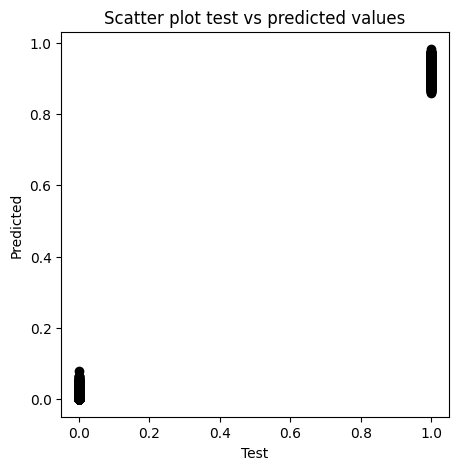

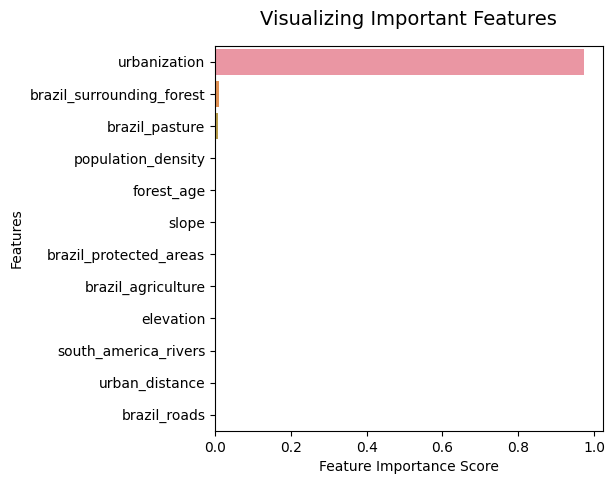

In [58]:
# On test set
y_pred_test, mae_test, mse_test, rmse_test, oob_score_test, r2_test, feature_imp_test = model_builder.evaluate(X_test=model_builder.X_test,
                                                                    y_test=model_builder.y_test,
                                                                    save_figures=False, saving_base_output_name='testing_test_set')

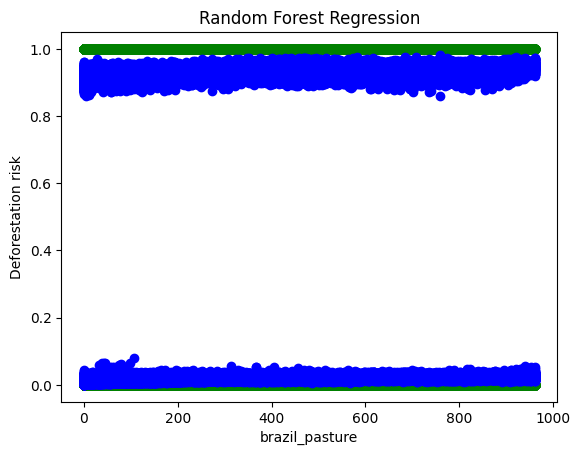

In [60]:
predictor = 'brazil_pasture'
plt.scatter(model_builder.X_test[predictor].values, model_builder.y_test, color = 'green')
plt.scatter(model_builder.X_test[predictor].values, y_pred_test, color = 'blue')
plt.title('Random Forest Regression')
plt.xlabel(predictor)
plt.ylabel('Deforestation risk')
plt.show()

# Inference on tiles

In [61]:
model_builder.inference(mask_band='forest_age', 
                        tiles_folder_name='Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster', 
                        tiles_in_GCP=False,   # Running locally
                        RF_output_folder_temp='TEST_RF_outputs_temp',
                        path_to_tiles_local='/Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster'
                       )


There are 58 inference tiles

Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_52.tif
Image opened
tile shape: (7422, 6857, 12)
Reshaped from (7422, 6857, 12) to (50892654, 12)
(50892654, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   38.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:  3.5min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 6857)
[ 0 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 86 91 93]
(7422, 6857)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-10_45_57_0.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_46.tif
Image opened
tile shape: (2665, 3127, 12)
Reshaped from (2665, 3127, 12) to (8333455, 12)
(8333455, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    9.4s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:   10.3s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (2665, 3127)
[ 0 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49]
(2665, 3127)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-10_46_14_1.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_8.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   26.9s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:  3.3min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[ 0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-10_51_26_2.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_9.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   36.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:  2.9min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[ 0 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-21-10_56_22_3.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_47.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.8s

KeyboardInterrupt

